## Example 1: Multiple linear regression

Import libraries

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
az.style.use('arviz-darkgrid')
np.random.seed(1234)

Read data

In [3]:
data = pd.read_csv('data/ESCS.csv')

Initialize and fit model

In [4]:
model = bmb.Model(data)
fitted = model.fit("drugs ~ o + c + e + a + n", draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [drugs_sigma, n, a, e, c, o, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.9093763587037988, but should be close to 0.8. Try to increase the number of tuning steps.


Plot model priors

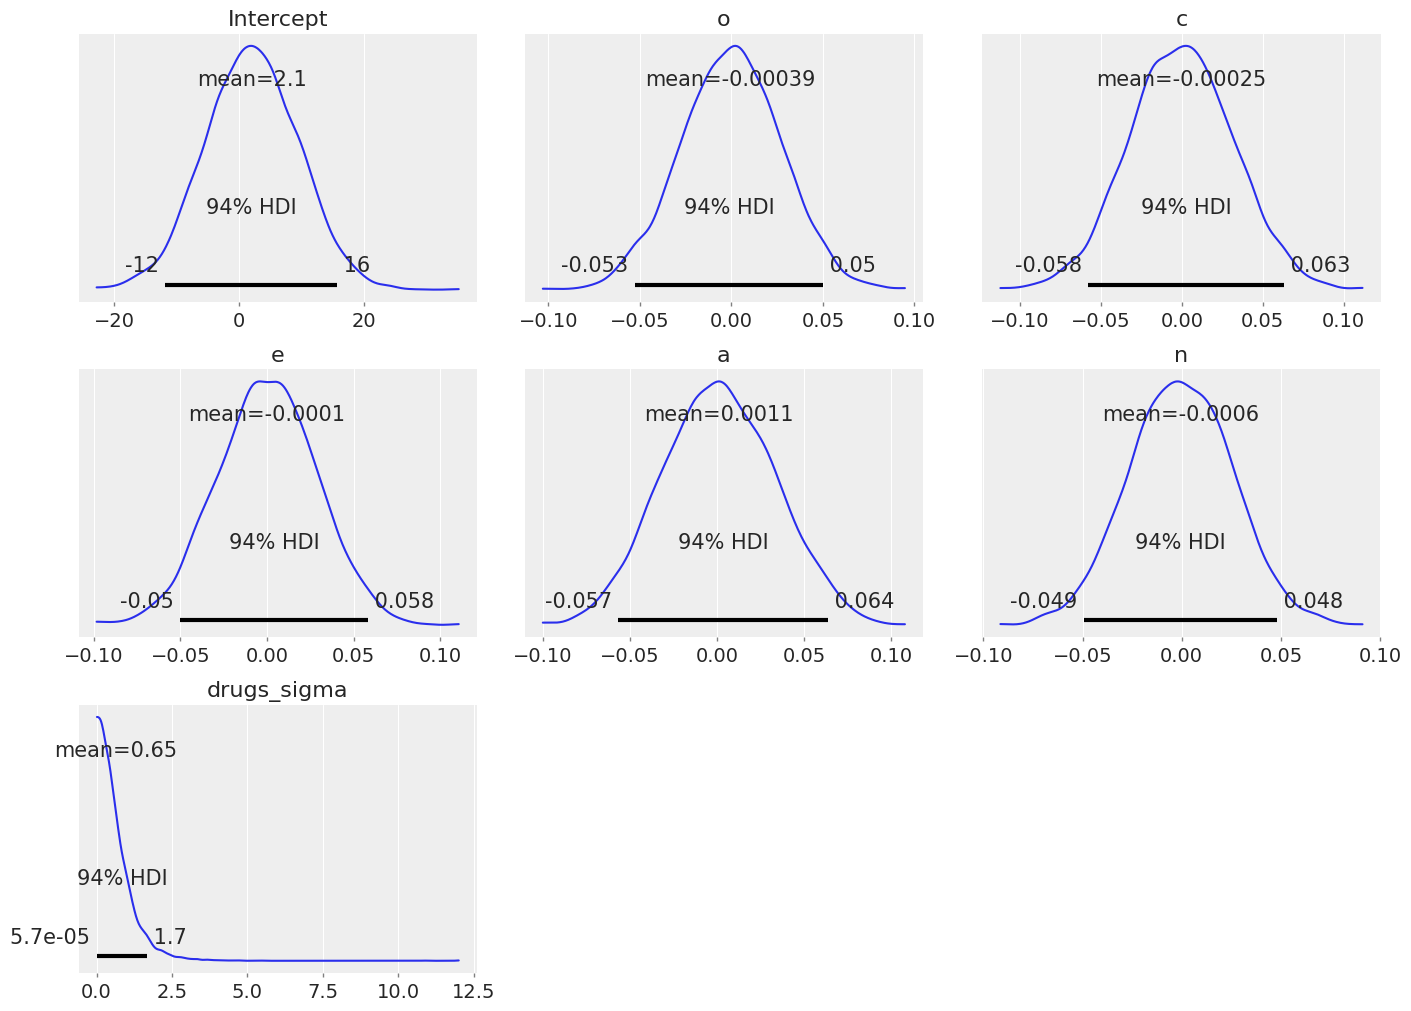

In [5]:
model.plot_priors(figsize = (14, 10));
plt.savefig("imgs/drugs_prior.png")

Inspection of InferenceData object

In [6]:
fitted

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Numerical summary of the posterior with diagnostics

In [7]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,3.302,0.354,2.672,3.977,0.009,0.006,1681.0,1955.0,1.0
o,0.006,0.001,0.004,0.008,0.000,0.000,2844.0,2589.0,1.0
c,-0.004,0.001,-0.007,-0.001,0.000,0.000,2357.0,2692.0,1.0
e,0.003,0.001,0.001,0.006,0.000,0.000,3312.0,2768.0,1.0
a,-0.012,0.001,-0.015,-0.010,0.000,0.000,2431.0,2487.0,1.0
n,-0.002,0.001,-0.004,0.001,0.000,0.000,2064.0,2381.0,1.0
drugs_sigma,0.592,0.017,0.558,0.622,0.000,0.000,2752.0,2389.0,1.0


Density estimates and traceplots of marginal posteriors

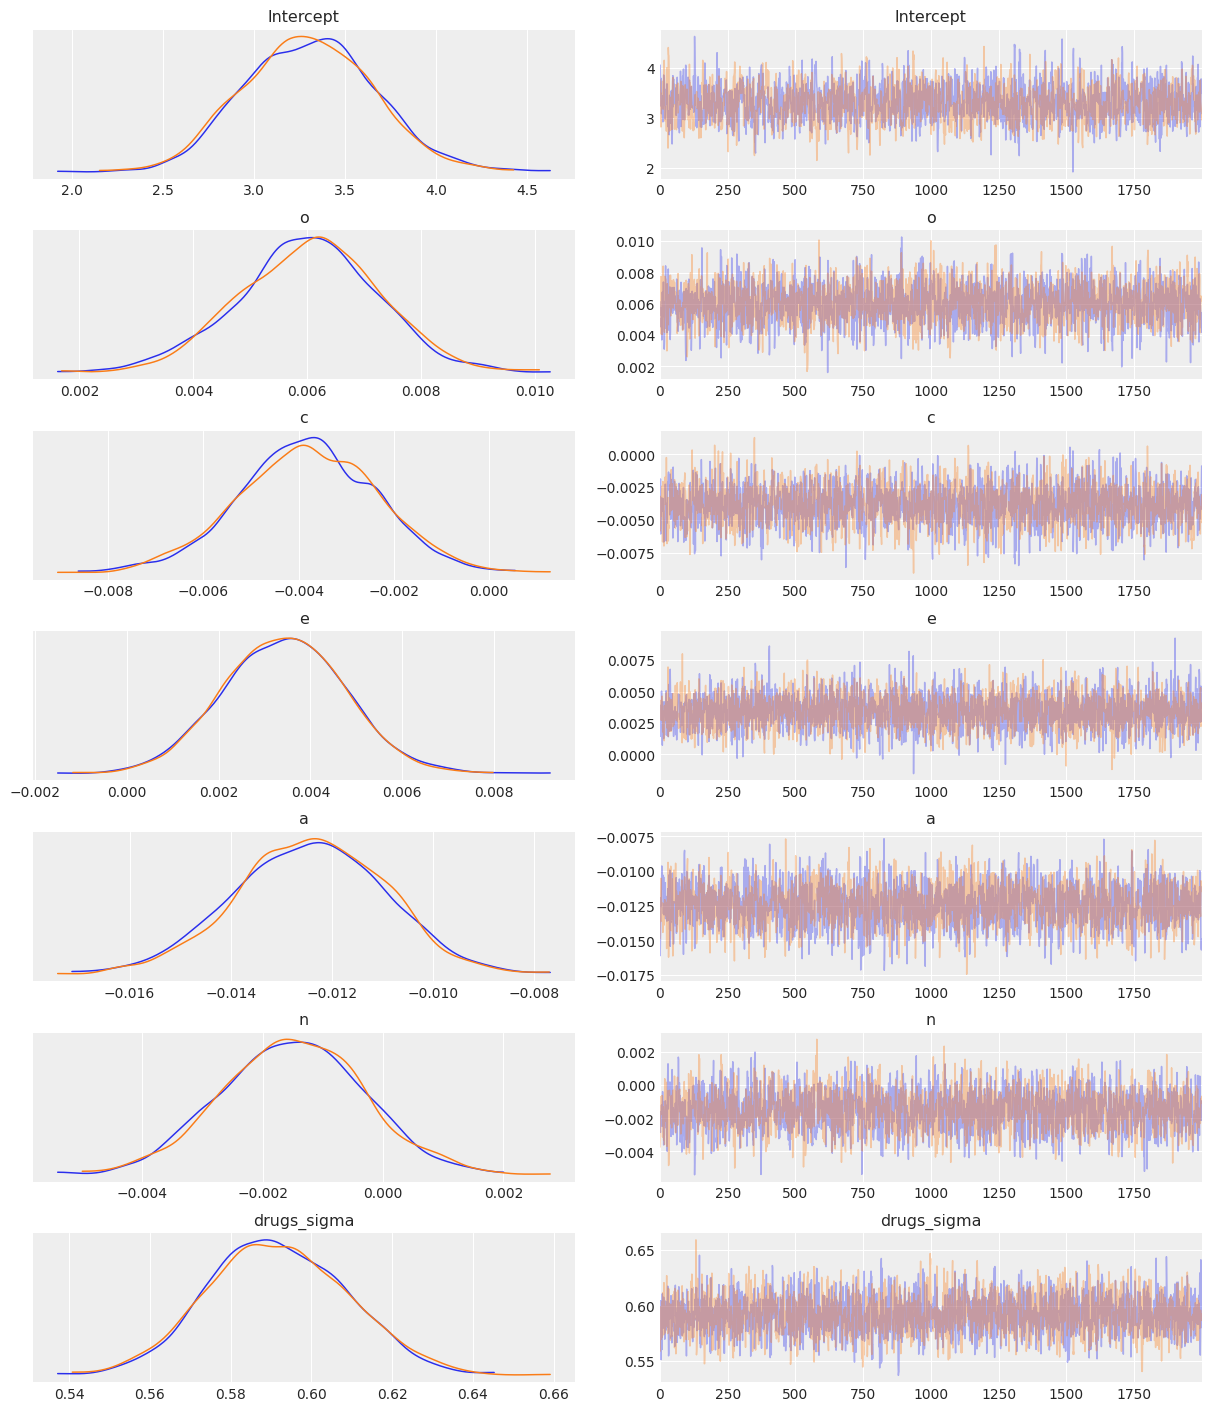

In [8]:
az.plot_trace(fitted, compact=False);
plt.savefig("imgs/drugs_posterior.png")

Summarize effects on partial correlation scale. First we compute some statistics.

In [9]:
# X = common effects design matrix (excluding intercept/constant term)
terms = [t for t in model.common_terms.values() if t.name != "Intercept"]

x_matrix = [pd.DataFrame(x.data, columns=x.levels) for x in terms]
x_matrix = pd.concat(x_matrix, axis=1)

dm_statistics = {
    "r2_x": pd.Series(
        {
            x: sm.OLS(
                endog=x_matrix[x],
                exog=sm.add_constant(x_matrix.drop(x, axis=1))
                if "Intercept" in model.term_names
                else x_matrix.drop(x, axis=1),
            )
            .fit()
            .rsquared
            for x in list(x_matrix.columns)
        }
    ),
    "sigma_x": x_matrix.std(),
    "mean_x": x_matrix.mean(axis=0),
}

In [10]:
samples = fitted.posterior

# the names of the predictors
varnames = ['o', 'c', 'e', 'a', 'n']

# compute the needed statistics
r2_x = dm_statistics['r2_x']
sd_x = dm_statistics['sigma_x']
r2_y = pd.Series([
    sm.OLS(
        endog=data['drugs'],
        exog=sm.add_constant(data[[p for p in varnames if p != x]])
    ).fit().rsquared for x in varnames], 
    index=varnames)
sd_y = data['drugs'].std()

# compute the products to multiply each slope with to produce the partial correlations
slope_constant = (sd_x[varnames] / sd_y) * ((1 - r2_x[varnames]) / (1 - r2_y)) ** 0.5
slope_constant

o    32.392557
c    27.674284
e    30.305117
a    26.113299
n    34.130431
dtype: float64

In [11]:
pcorr_samples = samples[varnames] * slope_constant

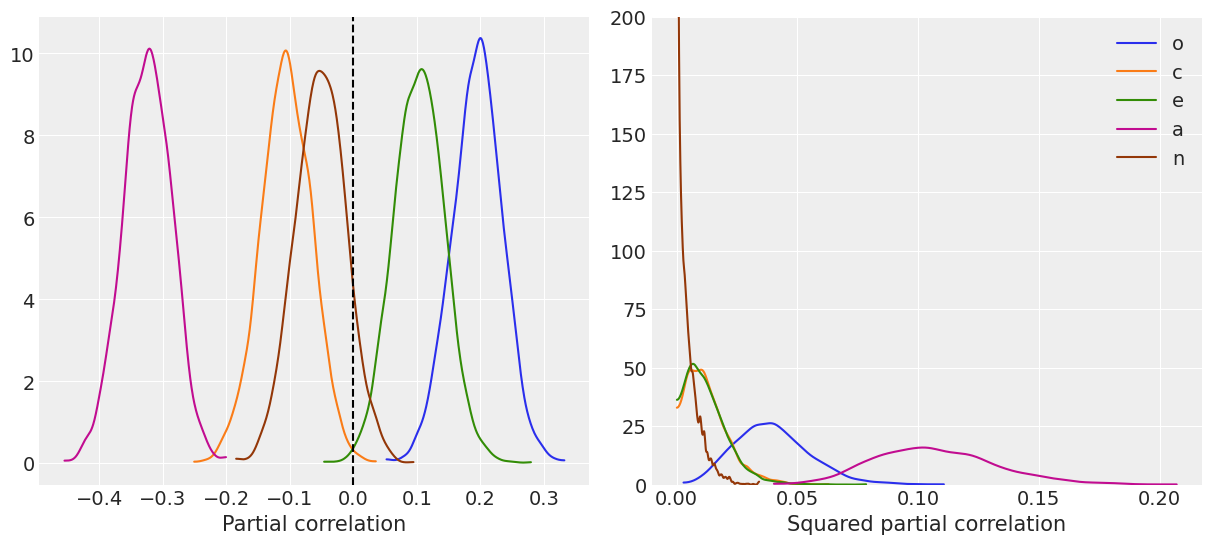

In [12]:
# Pass the same axes to az.plot_kde to have all the densities in the same plot
_, ax = plt.subplots(1, 2, figsize=(12, 5.33))
for idx, (k, v) in enumerate(pcorr_samples.items()):
    az.plot_kde(v, label=k, plot_kwargs={'color':f'C{idx}'}, ax=ax[0], legend=False)
    az.plot_kde(v**2, label=k, plot_kwargs={'color':f'C{idx}'}, ax=ax[1])
ax[0].axvline(x=0, color='k', linestyle='--');
ax[0].set_xlabel("Partial correlation")
ax[1].set_xlabel("Squared partial correlation")
ax[1].set_ylim(0, 200)
plt.savefig("imgs/drugs_pcorr.png")

The means of these distributions serve as good point estimates of the partial correlations:

In [13]:
pcorr_samples.mean(dim=['chain', 'draw']).squeeze(drop=True)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    o        float64 0.1951
    c        float64 -0.1055
    e        float64 0.1038
    a        float64 -0.3244
    n        float64 -0.05146

In [14]:
sq_partial_c = pcorr_samples['c'].stack(draws=("chain", "draw")).values ** 2
sq_partial_o = pcorr_samples['o'].stack(draws=("chain", "draw")).values ** 2

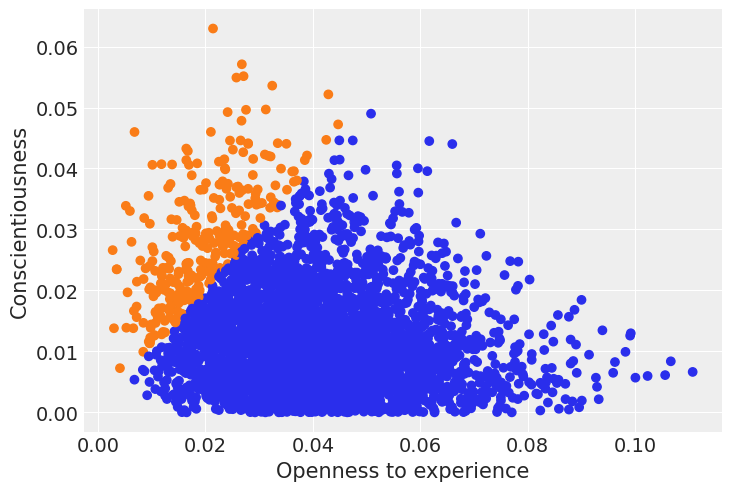

In [15]:
# Just grab first to colors from color map
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:2]
colors = [colors[1] if x > y else colors[0] for x, y in zip(sq_partial_c, sq_partial_o)]

plt.scatter(sq_partial_o, sq_partial_c, c=colors)
#plt.title("Samples from the joint posterior of\n Conscientiousness and Openness to experience")
plt.xlabel("Openness to experience")
plt.ylabel("Conscientiousness");
plt.savefig("imgs/drugs_scatter.png")

Probability that `o`^2 is larger than `c`^2.

In [16]:
(pcorr_samples['o'] ** 2 > pcorr_samples['c'] ** 2).mean()

<xarray.DataArray ()>
array(0.92625)

Correlation is not 0

In [17]:
np.corrcoef(sq_partial_c, sq_partial_o)[0, 1]

-0.18537574466978832

For each predictor, what is the probability that it has the largest squared partial correlation?

In [18]:
pc_df = pcorr_samples.to_dataframe()
(pc_df**2).idxmax(axis=1).value_counts() / len(pc_df.index)

a    0.99425
o    0.00550
c    0.00025
dtype: float64

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


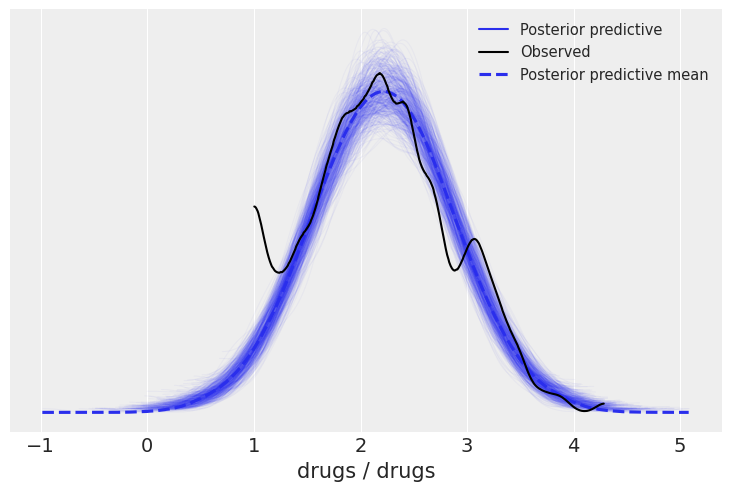

In [19]:
posterior_predictive = model.posterior_predictive(fitted)
az.plot_ppc(fitted, color="C0", alpha=0.04);
plt.savefig("imgs/drugs_ppc.png")

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Mar 08 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

numpy      : 1.20.1
statsmodels: 0.12.2
bambi      : 0.4.0
matplotlib : 3.3.3
pandas     : 1.2.2
arviz      : 0.11.2

Watermark: 2.1.0

